In [1]:
library(jsonlite)
library(ggplot2)
library(ggtree)
library(aplot)
suppressPackageStartupMessages(library(VennDiagram))

DATA_DIR <- file.path("Data", "SARS-CoV-2_genome")
OUTPUT_DIR <- "Output"

ggtree v3.0.2  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36. doi:10.1111/2041-210X.12628





# hyphy result

In [4]:
hyphySlac <- read_json(file.path(DATA_DIR, "2021-05-03_S.nexus.SLAC.json"))

In [5]:
resolved <- hyphySlac[["MLE"]][["content"]][[1]][["by-site"]][["RESOLVED"]]
names(resolved) <- seq_along(resolved)

In [6]:
contentNames <- sapply(hyphySlac[["MLE"]][["headers"]], "[[", 1)

selectedSites <- which(sapply(resolved, function(site) {
    if (site[[3]] + site[[4]] != 0) {
        return(site[[9]] < 0.05 | site[[10]] < 0.05)
    }
    return(FALSE)
}))
selectedSites <- resolved[selectedSites]

selectedSites <- do.call(rbind, lapply(names(selectedSites), function(siteName) {
    site <- selectedSites[[siteName]]
    pValues <- c(site[[9]], site[[10]])
    i <- which(pValues < 0.05)
    data.frame(
        "site" = as.integer(siteName),
        "test" = contentNames[9:10][[i]],
        "pValue" = pValues[[i]]
    )
}))

selectedSites <- selectedSites[which(selectedSites$test == "P [dN/dS > 1]"), ]

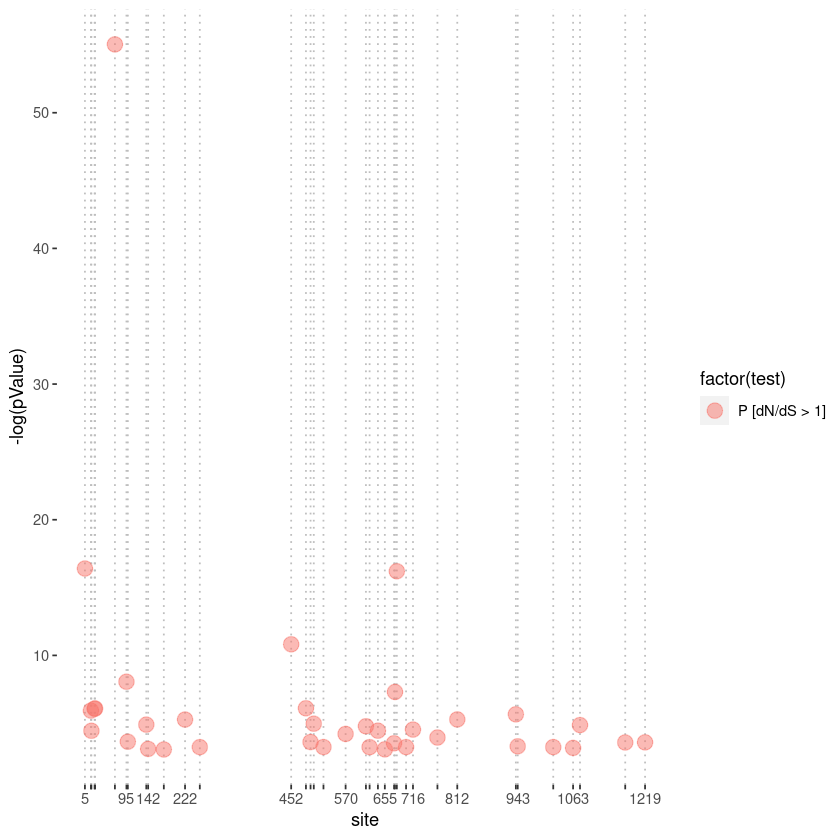

In [7]:
p <- ggplot(selectedSites, aes(x = site, y = -log(pValue), color = factor(test))) +
    geom_point(size = 4, alpha = 0.5) +
    scale_x_continuous(breaks = selectedSites$site,
                       guide = guide_axis(check.overlap = TRUE)) +
    theme(
        panel.background = element_rect(fill = "white"),
        panel.grid.major.x = element_line(
            colour = "grey",
            linetype = 3,
        )
    )
p

ggsave(filename = file.path(OUTPUT_DIR, "hyphy_S.pdf"), plot = p, width = 15, height = 4)

# hyphy and sitePath comparison

In [8]:
df <- read.csv(file.path(DATA_DIR, "paraFixSites.csv"))
df[which(df$type == "paraFix"), "type"] <- "parallel"

In [9]:
sitePathResults <- df[which(df[["product"]] == "S" & df[["date"]] == "2021-05-03"), "aaPos"]
hyphyResults <- selectedSites[["site"]]

In [10]:
setdiff(hyphyResults, sitePathResults)

[1]    5   19   27   70   95   98  142  176  254  494  522  622  640  675  769
[16]  812  939  943 1020 1063 1078 1219

In [11]:
setdiff(sitePathResults, hyphyResults)

[1]   13   20   52   67   80  152  157  190  215  367  417  439  477  478  613
[16]  732  888  982 1027 1118

In [12]:
intersect(sitePathResults, hyphyResults)

[1]   18   26  138  222  452  484  501  570  614  655  677  681  701  716 1176

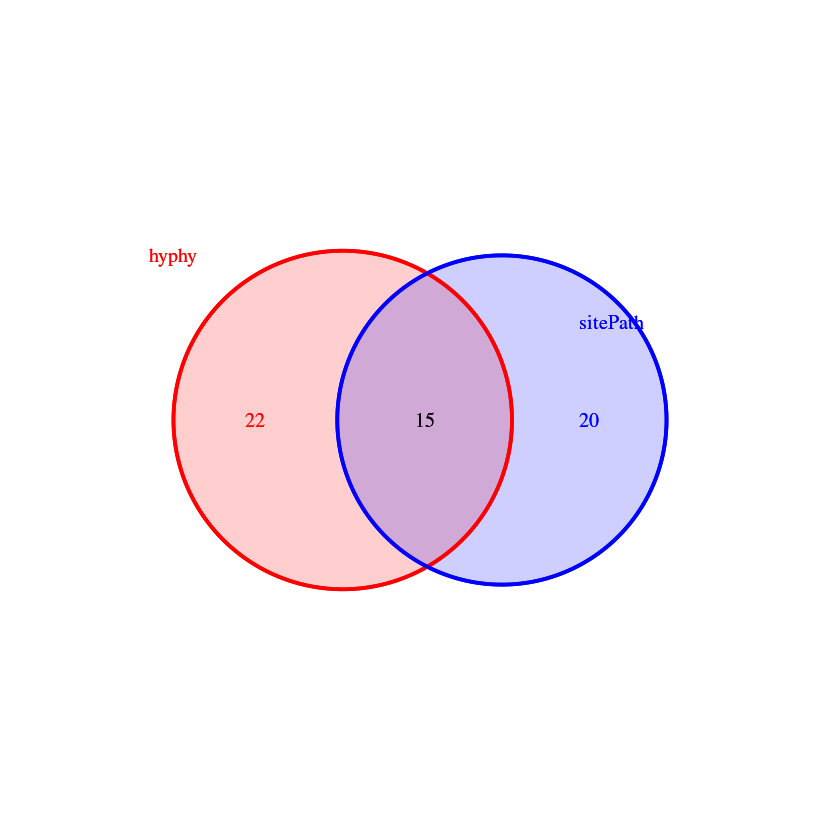

In [13]:
venn.plot <- draw.pairwise.venn(
    area1 = length(sitePathResults),
    area2 = length(hyphyResults),
    cross.area = length(intersect(sitePathResults, hyphyResults)),
    category = c("sitePath", "hyphy"),
    ext.text = FALSE,
#     offset = 1,
    fill = c("blue", "red"),
    alpha = c(0.1, 0.1),
    lwd = c(3, 3),
    col = c("blue", "red"),
    label.col = c("blue", "black", "red"),
    cat.col = c("blue", "red"),
    cat.just = list(c(1, -15), c(1, -20)),
#     rotation.degree = 180,
    margin = 0.2
)
grid.draw(venn.plot)

pdf(file = file.path(OUTPUT_DIR, "hyphy_S_venn.pdf"))
grid.draw(venn.plot)
invisible(dev.off())

# B.1.351 K417N reverse mutation

In [14]:
tree <- read.tree(file.path(DATA_DIR, "B.1.351.treefile"))

lineageInfo <- read.csv(file.path(DATA_DIR, "B.1.351_mutInfo.csv"))
lineageInfo[["date"]] <- as.Date(lineageInfo[["date"]])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



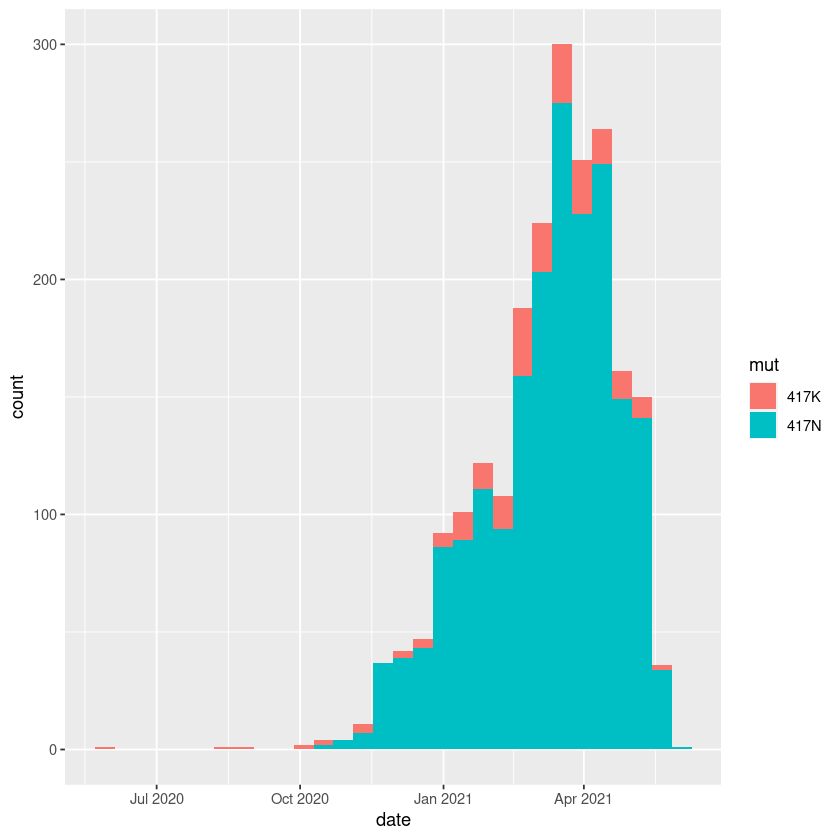

In [15]:
ggplot(lineageInfo, aes(date, fill = mut)) + 
    geom_histogram()

In [16]:
tree


Phylogenetic tree with 2149 tips and 2147 internal nodes.

Tip labels:
  EPI_ISL_402125, EPI_ISL_510845, EPI_ISL_1094653, EPI_ISL_1663970, EPI_ISL_2158562, EPI_ISL_1824394, ...
Node labels:
  , 64, 74, 96, 100, 48, ...

Unrooted; includes branch lengths.

Saving 6.67 x 6.67 in image



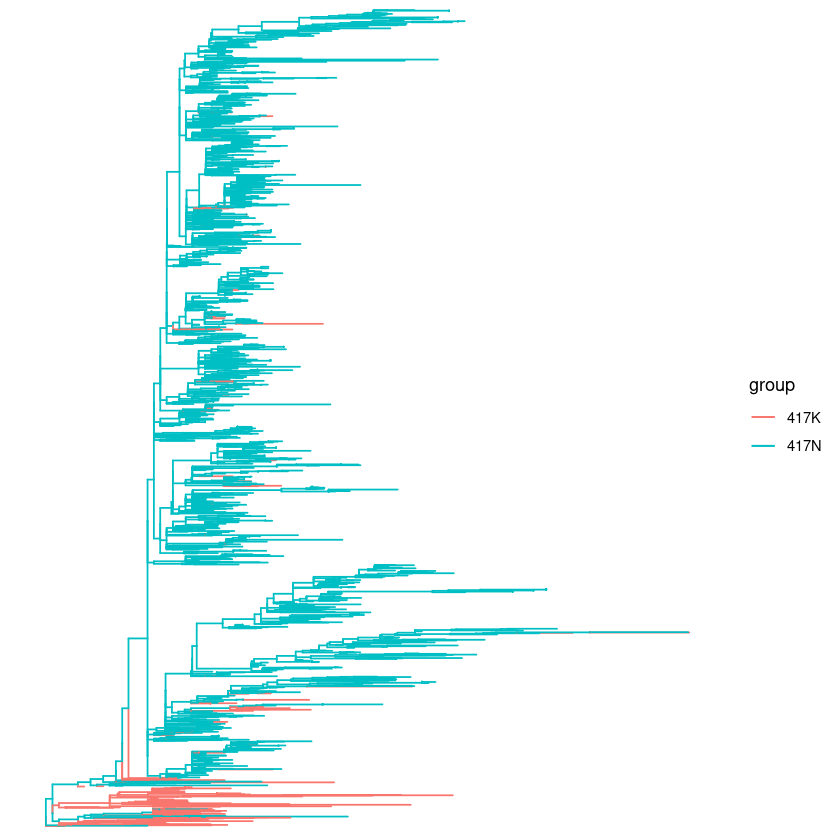

In [17]:
lineageInfo <- rbind(lineageInfo,
                     data.frame("mut" = "417K", "accession" = "EPI_ISL_402125", date = as.Date("2019-12-31")))

p <- ggtree(groupOTU(tree, split(lineageInfo[["accession"]], lineageInfo[["mut"]])), aes(color = group))
p

ggsave(filename = file.path("Output", "ReverseMut", "K417_revMut_tree.pdf"), plot = p)

# P.1-4 K417T reverse mutation

In [18]:
tree <- read.tree(file.path(DATA_DIR, "P.1-4.treefile"))

lineageInfo <- read.csv(file.path(DATA_DIR, "P.1-4_mutInfo.csv"))
lineageInfo[["date"]] <- as.Date(lineageInfo[["date"]])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



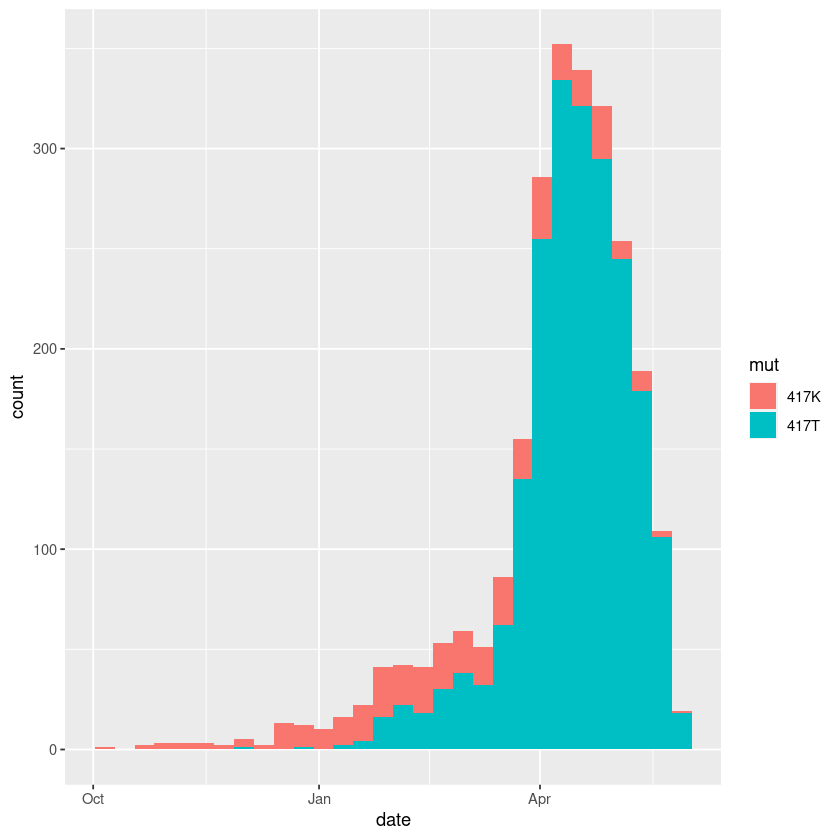

In [19]:
ggplot(lineageInfo, aes(date, fill = mut)) + 
    geom_histogram()

In [20]:
tree


Phylogenetic tree with 2492 tips and 2490 internal nodes.

Tip labels:
  EPI_ISL_402125, EPI_ISL_668335, EPI_ISL_1541385, EPI_ISL_1909519, EPI_ISL_897698, EPI_ISL_1001421, ...
Node labels:
  , 70, 95, 42, 100, 80, ...

Unrooted; includes branch lengths.

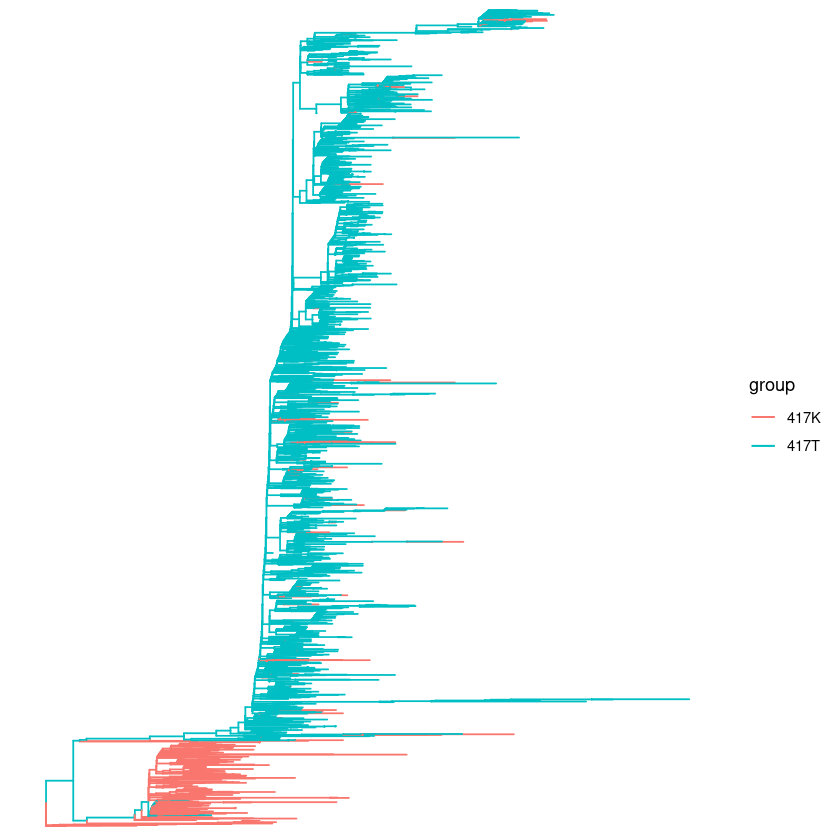

In [21]:
lineageInfo <- rbind(lineageInfo,
                     data.frame("mut" = "417K", "accession" = "EPI_ISL_402125", date = as.Date("2019-12-31")))

p <- ggtree(groupOTU(tree, split(lineageInfo[["accession"]], lineageInfo[["mut"]])), aes(color = group))
p

# ggsave(filename = file.path("Output", "ReverseMut", "K417_revMut_tree.pdf"), plot = p)